In [1]:
import numpy as np
from numpy import random
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
import math, decimal
from math import exp
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from xgboost import XGBClassifier,XGBRFClassifier
from collections import Counter


In [2]:
train = pd.read_csv("train.csv", index_col = None)
y = train[['LABELS']]
x = train.drop('LABELS', axis=1)
xMean = x.mean()
x = x.fillna(xMean)
test_nolabels = pd.read_csv("test_nolabels.csv", index_col = None)
test_nolabels = test_nolabels.fillna(xMean)

In [3]:
toposElevation = {"topo_elevation_jan",'topo_elevation_feb','topo_elevation_mar','topo_elevation_apr','topo_elevation_may','topo_elevation_jun','topo_elevation_jul','topo_elevation_aug','topo_elevation_sep','topo_elevation_oct','topo_elevation_nov','topo_elevation_dec'}
topoSlope = {'topo_slope_jan','topo_slope_feb','topo_slope_mar','topo_slope_apr','topo_slope_may','topo_slope_aug','topo_slope_jun','topo_slope_jul','topo_slope_sep','topo_slope_oct','topo_slope_nov','topo_slope_dec'}
topoElevationDF = x[toposElevation]
topoElevationMean = topoElevationDF.mean(axis=1)
x = x.drop(toposElevation,axis=1)
x['topoElevationMean'] = topoElevationMean
topoSlopeDF = x[topoSlope]
topoSlopeMean = topoSlopeDF.mean(axis=1)
x = x.drop(topoSlope, axis=1)
x['topoSlope'] = topoSlopeMean

In [4]:
### Data manipulation and helper methods  ###
def meanStd(dataset):
    '''
    dataset_minmax(dataset)
    return a list like {min:#,max:#}
    # Find the min and std values for each column
    '''
    col = dataset.shape[1]
    meanVal, stdVal = 0,0
    stats = list()
    for i in range(col):
        val = dataset.iloc[:, i]
        meanVal = np.mean(val)
        stdVal = np.std(val)
        stats.append([meanVal,stdVal])
    return stats

def standardize_data(dataset, mean_std):
    '''
    standardize_data(dataset, mean_std)
    @mean_std: @arguent: list of min/max valuer per column {min:#,max:#}
    # Rescale dataset columns to the range 0-1
    '''
    col = dataset.shape[1]
    row = dataset.shape[0]
    for i in range(1,col):
        for n in range(row):
            dataset.iloc[n,i] -= mean_std[i][0]
            dataset.iloc[n,i] /= mean_std[i][1]
    return dataset


In [5]:
mean_std_x_train = meanStd(x)
x = standardize_data(x, mean_std_x_train)
x.to_csv('x_standardized.csv')

In [ ]:
print(x.had(10))

In [ ]:
x.to_csv('x_standardized.csv')

In [16]:
#preprocessing No_label datase:
test_nolabels = test_nolabels.fillna(xMean)
test_nolabels = test_nolabels.drop(toposElevation, axis=1)
test_nolabels = test_nolabels.drop(topoSlope, axis=1)
test_nolabels['topoElevationMean'] = topoElevationMean
test_nolabels['topoSlope'] = topoSlopeMean

In [ ]:
mean_std_x_noLabel = meanStd(test_nolabels)
test_nolabels = standardize_data(test_nolabels, mean_std_x_noLabel)

In [11]:
x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)
y_train = (np.array(y_train).astype('int')).ravel()
y_validation = (np.array(y_validation).astype('int')).ravel()

In [ ]:
## Data shape exploration
print("",np.shape(x_train),"  :",np.shape(x_validation) )
print("Label balance on Training set: ", "\n", y_train['LABELS'].value_counts())
print("Label balance on Validation set: ", "\n", y_validation['LABELS'].value_counts())

In [13]:
### Some helpers function
# To adapt the prediction to Kaggel format of submission 
def formating_prediction(predictions): 
        '''
        Return the prediction in the Kaggle format submition
        @hypotesis : column of classes 
        '''
        y_hat = pd.DataFrame({'S.No' : [],'LABELS' : []}, dtype=np.int8) 
        for i in range(len(predictions)):
            y_hat.loc[i] = [i,predictions[i]]
        return pd.DataFrame(data = y_hat) 

def predictOnSet(model, x_test):
    prediction = model.predict(x_test)
    return prediction

def savingModels(classifier, modelFileName):
    '''
    NOTE: Do not forget the extention = *.pkl
    Save as : 'modelFileName.pkl'
    '''
    joblib.dump(classifier, modelFileName)


def importModel(modefname):
    model = joblib.load(modefname)
    return model

def savePrediction(prediction, filename):
    '''
    Save predictions
    @argument: filename: Remenber EXTENTION 'filename.csv'
    '''
    prediction = prediction.astype('int32') #exsure prediction as integer
    predictions_DF = formating_prediction(prediction)
    return predictions_DF.to_csv(filename, index = None)

## modle evaluation
def metric_RocAuc(y_probability, y_validation, estimator_name):
    '''
    Calculate and plt ROC metric
    @argument: y_probability : the probability class=1.
    @argument: y_validation: True labels.
    fpr, tpr = false_positive, true_positive.
    Return: "false_positive" and "true_positive", ROC_auc metric.
    '''
    fpr, tpr, _ = roc_curve(y_validation, y_probability) 
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(constrained_layout=True,figsize=(5,3), dpi=150)
    fig.suptitle(estimator_name)
    axes.plot([0, 1], [0, 1], color= 'k',linestyle="--") # perfect fit 
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name=estimator_name)
    display.plot(ax=axes)
    return fpr, tpr, roc_auc

## Show some evaluation criteria on the clasifier
def evaluate_model(x_train, y_train, x_validation, y_validation, classifier):
    features = x_train.columns
    validation_Prediction = classifier.predict(x_validation)
    validation_PredictedProb = classifier.predict_proba(x_validation)[:, 1]
    ### ROC metric and curve #####
    clasifierName = type(classifier).__name__
    metric_RocAuc(validation_PredictedProb, y_validation,clasifierName)
    fi_model = pd.DataFrame({'feature': features,
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)
    clasifierNameExtended = clasifierName + "_info_fi"     
    fi_model.to_csv(clasifierNameExtended, index = None)
    return fi_model

In [ ]:
#### Ramdomized RF  ####
# Hyperparameter grid NOTE: Grid search was transformed several time to enlage the exploration. 
# Best ramdom seach grid has been publiched in the Report
param_grid = {
    'n_estimators': np.linspace(10, 400,20).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seedRF)
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seedRF)
# Random searsh  
y_train = np.array(y_train).ravel()
rs.fit(x_train, y_train)
print(rs.best_params_, "\n")
### Working with best estimator from RandomizedSearch 
best_model = rs.best_estimator_
savingModels(best_model, "rf_RandomSearch.pkl")
## Evaluating ROC Curve and extracting features priority
fi_model = evaluate_model(x_train, y_train, x_validation, y_validation, test_nolabels_prediction)
## Predicting on No_Labeled dataset and saving prediction ready to submit
test_nolabels_prediction = predictOnSet(best_model, test_nolabels)
savePrediction(test_nolabels_prediction, 'first_rfSearch_noLabelPrediction.csv')

In [ ]:
## XGBClassifier

estimator = XGBClassifier(use_label_encoder=False,subsample=0.9, colsample_bynode=0.2)
param_grid = {
    'n_estimators': np.linspace(50, 500, 10).astype(int),
    'max_depth': [None] + list(np.linspace(3,20,5).astype(int)),
    'max_features': [None] + list(np.arange(0.2, 0.9, 0.1)),
    'bootstrap': [True]
}
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 4, verbose = 1, random_state=47)

rs.fit(x_train, y_train)
print(rs.best_params_, "\n")
model = rs.best_estimator_

savingModels(model, "XGBClassifierGridSearh.pkl")

# To monitor evolution on mode.fit() and find the early soping point
eval_set = [(x_validation, y_validation)]
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=True)

savingModels(model, "XGBClassifierGridSearh.pkl")


KeyError: 'validation_1'

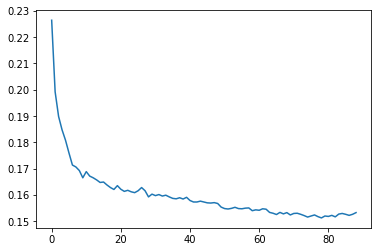

In [42]:
### ploting the model behavior on train and validation datasets over epochs
eval_set = [(x_train, y_train),(x_validation, y_validation)]
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
pyplot.ylabel('log_loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

,feature,importance
14,ERA5_temperature_2m_jan,0.039202
193,topoElevationMean,0.021640
190,ERA5_temperature_2m_dec,0.019970
126,ERA5_temperature_2m_aug,0.019733
143,ERA5_total_precipitation_sep,0.019185
...,...,...
70,S2_B7_may,0.002589
104,S2_B8A_jul,0.002504
183,S2_B8_dec,0.002464
168,S2_B8A_nov,0.002269


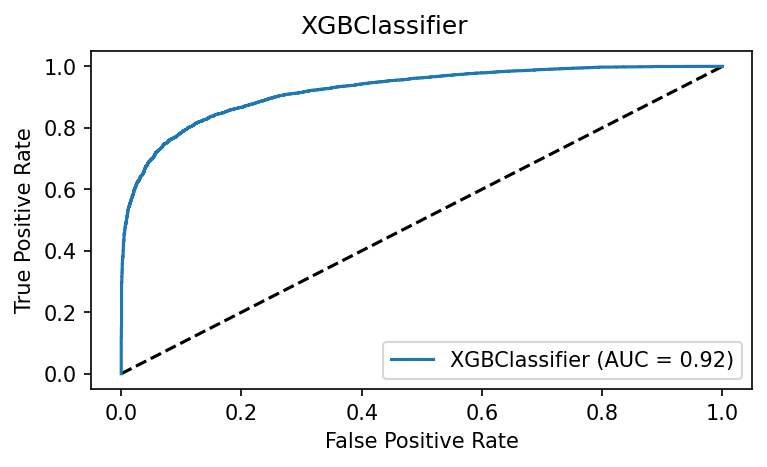

In [32]:
## ROC metric 
evaluate_model(x_train, y_train, x_validation, y_validation, model)

In [33]:

test_nolabels_prediction = predictOnSet(model, test_nolabels)
savePrediction(test_nolabels_prediction, 'XGBoost_EarlyStop.csv')

In [ ]:
## Calculating F1 metrics for all produced models
modelNameList =  list{}

for model in modelNameList:
    model = pd.(model, index_col = None)
    model.fit(x_train, y_train) 
    y_hat = model.predict(x_validation)
    f1 = f1_score(model, x_validation,y_validation, average ='binary',zero_division = 0)
    roc = roc_auc_score(y_validation, y_hat)
    print("quality of prediction of " + model + ", f1_score:", f1, ", ROC: ", roc,"\n",)
    
